In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics_portfolio import PortfolioManager

from careamics.config.configuration_factories import create_n2v_configuration
from careamics.lightning.dataset_ng.lightning_module import N2VModule
from careamics.lightning.dataset_ng.data_module import CareamicsDataModule

Text(0.5, 1.0, 'Validation Image')

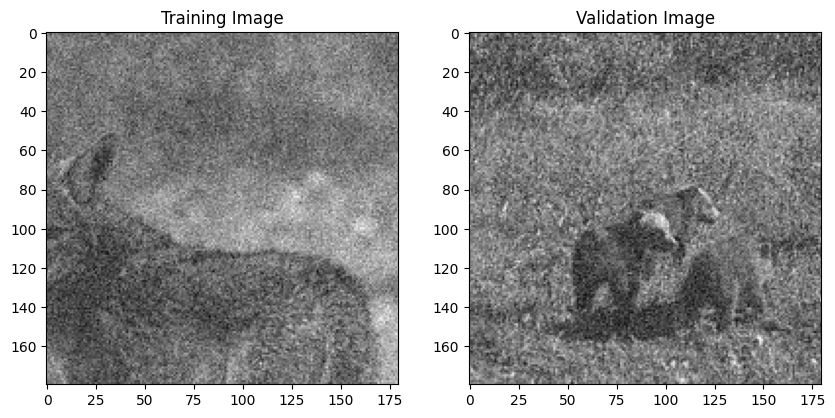

In [3]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_BSD68.download(root_path)

# create paths for the data
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

# load training and validation image and show them side by side
train_files = sorted(train_path.rglob("*.tiff"))
val_files = sorted(val_path.rglob("*.tiff"))
test_files = sorted(test_path.rglob("*.tiff"))

single_train_image = tifffile.imread(train_files[0])[0]
single_val_image = tifffile.imread(val_files[0])[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(single_train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(single_val_image, cmap="gray")
ax[1].set_title("Validation Image")

In [28]:
config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=100
)

config.data_config.set_means_and_stds([single_train_image.mean()], [single_train_image.std()] )

model = N2VModule(config.algorithm_config)


data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=train_files,
    val_data=val_files,
)

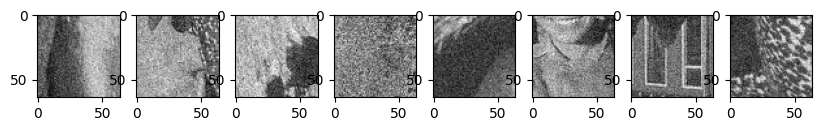

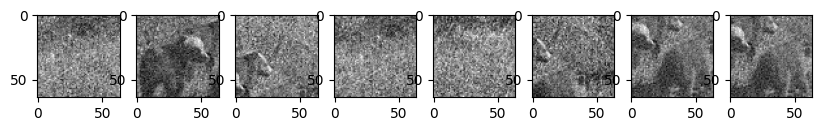

In [29]:
data_module.setup('fit')
data_module.setup('validate')

train_batch = next(iter(data_module.train_dataloader()))
val_batch = next(iter(data_module.val_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(train_batch[0].data[i][0].numpy(), cmap="gray")


fig, ax = plt.subplots(1, 8, figsize=(10, 5))
for i in range(8):
    ax[i].imshow(val_batch[0].data[i][0].numpy(), cmap="gray")

In [88]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

root = Path("bsd68_n2v")
callbacks = [
    ModelCheckpoint(
        dirpath=root / "checkpoints",
        filename="bsd68_lightning_api",
        save_last=True,
    )
]

# Create a Lightning Trainer
trainer = Trainer(max_epochs=10, default_root_dir=root, callbacks=callbacks)

# Train the model
trainer.fit(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/vera.galinova/micromamba/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/vera.galinova/dev/repos/careamics/src/careamics/dataset_ng/demos/bsd68_n2v/checkpoints exists and is not empty.

  | Name  | Type | Params | Mode
--------------------------------------
0 | model | UNet | 509 K  | eval
--------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
0         Modules in train mode
39        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/vera.galinova/micromamba/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/vera.galinova/micromamba/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [89]:
from careamics.config.inference_model import InferenceConfig

config = InferenceConfig(
    model_config=config,
    data_type="tiff",
    tile_size=(128, 128),
    tile_overlap=(32, 32),
    axes="YX",
    batch_size=1,
    image_means=data_module.train_dataset.input_stats.means,
    image_stds=data_module.train_dataset.input_stats.stds
)

inf_data_module = CareamicsDataModule(
    data_config=config,
    pred_data=test_files
)

In [97]:
from careamics.dataset_ng.legacy_interoperability import imageregions_to_tileinfos
from careamics.prediction_utils import convert_outputs

predictions = trainer.predict(model, datamodule=inf_data_module)

Predicting: |          | 0/? [00:00<?, ?it/s]

ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
ababa
abab

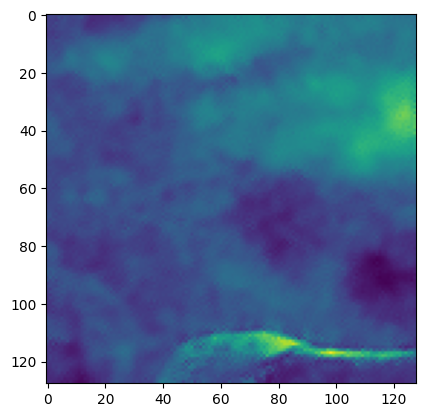

In [98]:
plt.imshow(predictions[0][0][0][0])

In [99]:
is_tiled = predictions[0].is_tiled
tile_infos = imageregions_to_tileinfos(predictions)
predictions = convert_outputs(list(tile_infos), is_tiled)

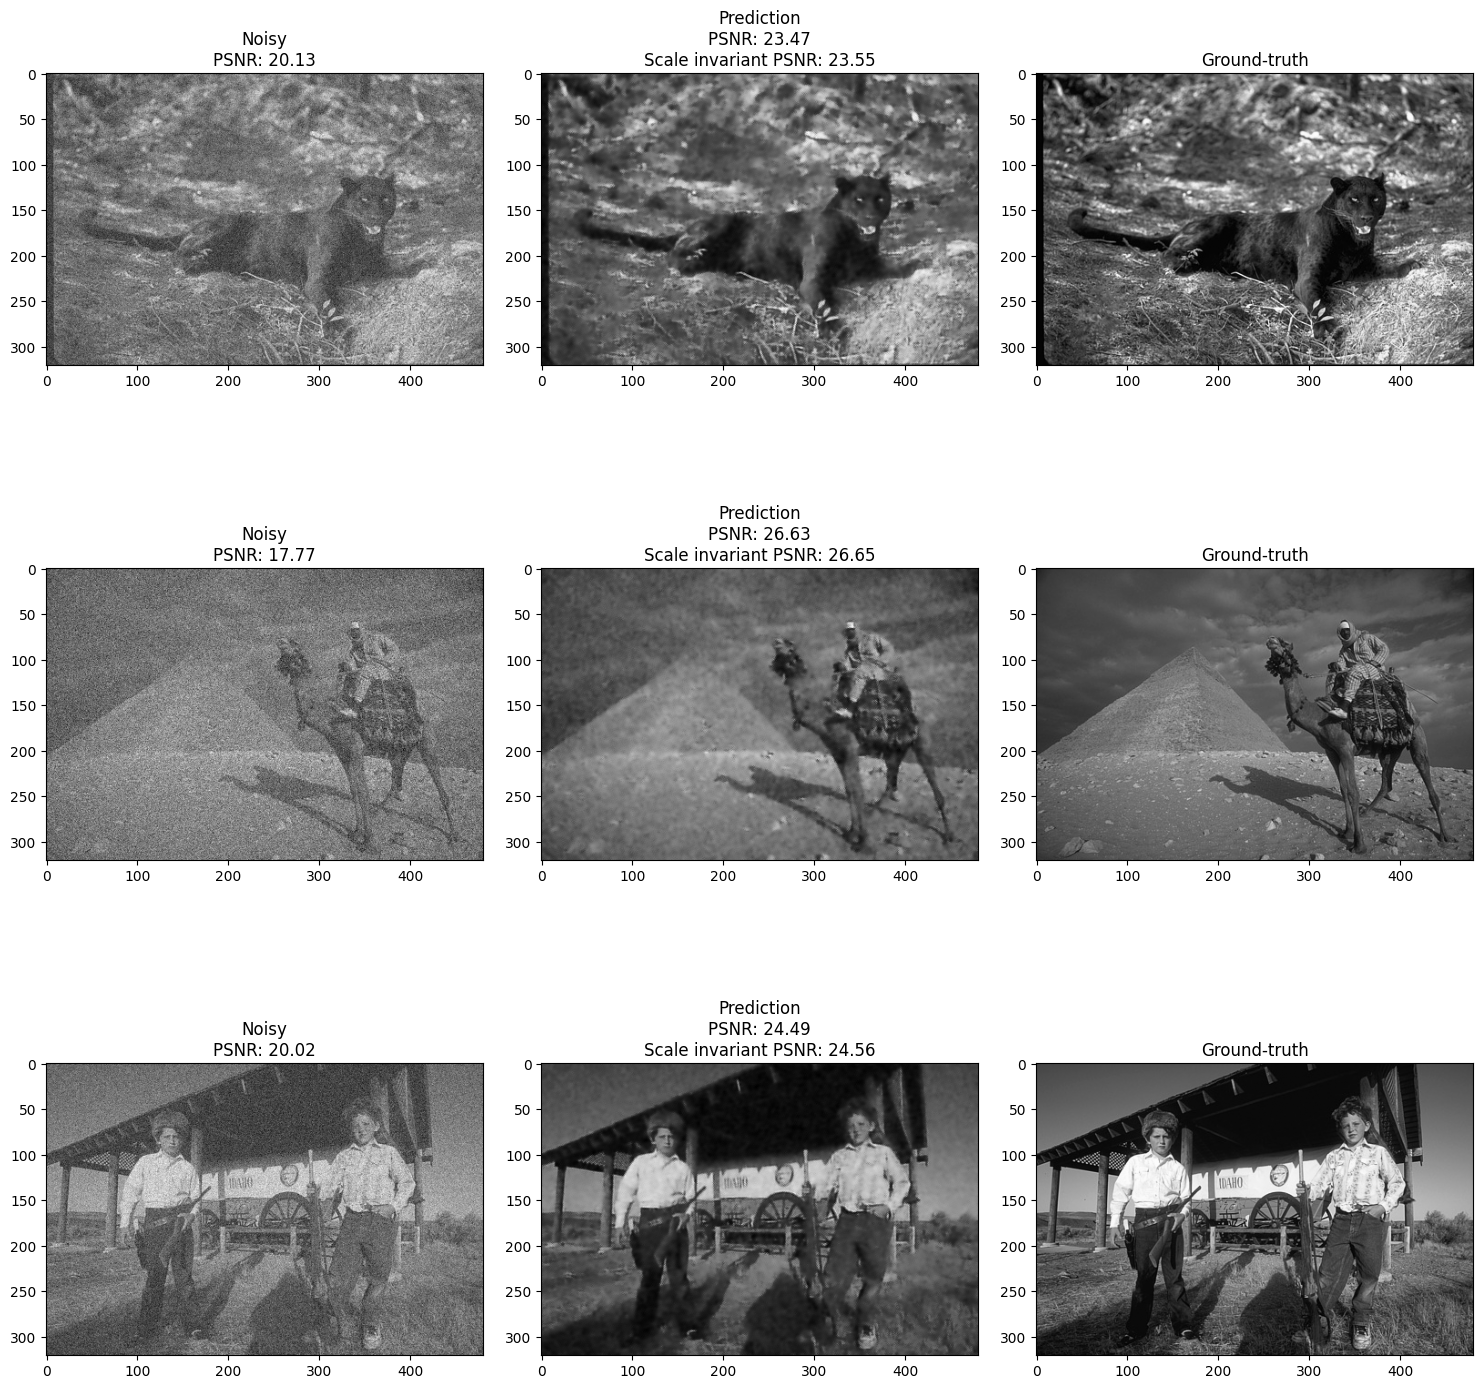

In [100]:
from careamics.utils.metrics import psnr, scale_invariant_psnr

# Show two images
noises = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
gts = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

# images to show
images = np.random.choice(range(len(noises)), 3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    pred_image = predictions[images[i]].squeeze()
    psnr_noisy = psnr(gts[images[i]], noises[images[i]], data_range=gts[images[i]].max() - gts[images[i]].min())
    psnr_result = psnr(gts[images[i]], pred_image, data_range=gts[images[i]].max() - gts[images[i]].min())

    scale_invariant_psnr_result = scale_invariant_psnr(gts[images[i]], pred_image)

    ax[i, 0].imshow(noises[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}\nScale invariant PSNR: {scale_invariant_psnr_result:.2f}")

    ax[i, 2].imshow(gts[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")


In [101]:
psnrs = np.zeros((len(predictions), 1))
scale_invariant_psnrs = np.zeros((len(predictions), 1))

for i, (pred, gt) in enumerate(zip(predictions, gts)):
    psnrs[i] = psnr(gt, pred.squeeze(), data_range=gt.max() - gt.min())
    scale_invariant_psnrs[i] = scale_invariant_psnr(gt, pred.squeeze())

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")
print(f"Scale invariant PSNR: {scale_invariant_psnrs.mean():.2f} +/- {scale_invariant_psnrs.std():.2f}")
print("Reported PSNR: 27.71")

PSNR: 25.34 +/- 2.40
Scale invariant PSNR: 25.48 +/- 2.44
Reported PSNR: 27.71
